# Coronavirus tweets classification | NLP 🦠 

Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

Columns:

1) Location

2) Tweet At

3) Original Tweet

4) Label

Please leave an upvote if you find this relevant. P.S. I am new and it will help immensely. :)
Other Datasets:

1) Guns dataset: https://www.kaggle.com/datatattle/guns-incident-data

2) Sales Prediction: https://www.kaggle.com/datatattle/sales-prediction-dt-mart-retail

3) Retail Sales: https://www.kaggle.com/datatattle/dtmart-retail-sales

More detail: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

## Download data and visualize data

In [1]:
# upload file kaggle.json
from google.colab import files
files.upload()

{}

In [2]:
# Dowload data from kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!ls ~/.kaggle 
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

kaggle.json
covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip /content/covid-19-nlp-text-classification.zip

Archive:  /content/covid-19-nlp-text-classification.zip
replace Corona_NLP_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


### Read data

In [4]:
import pandas as pd
from google.colab import data_table
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

data_table.enable_dataframe_formatter()

In [5]:
df_train = pd.read_csv('/content/Corona_NLP_train.csv', encoding = "ISO-8859-1")
df_test = pd.read_csv('/content/Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [6]:
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [7]:
len(df_train), len(df_test)

(41157, 3798)

### Visualize data 

In [8]:
count_classes = df_train['Location'].value_counts()
count_classes

London                            540
United States                     528
London, England                   520
New York, NY                      395
Washington, DC                    373
                                 ... 
Yellowknife                         1
Atlanta University Center           1
???? ?????? ????? 9935943398        1
ÃT: 36.319708,-82.363649           1
City Hall 121 N LaSalle Rm 805      1
Name: Location, Length: 12220, dtype: int64

In [9]:
count_classes[:10]

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [10]:
def plot_pie(df, column, axes, amount = -1):
    '''
    PLOT PIE
    -------------
    df: datafarme read form dataset
    columns: columns of df you want visualize
    axes: position of plot
    amount: numbers of classes you want show in the plot
    '''
    
    count_classes = df[column].value_counts() # return amount of each class
    if (amount != -1):
        count_classes = count_classes[:amount]

    n_classes = len(count_classes)
    colors = sns.color_palette('pastel')
    explode = (0.1, )*n_classes

    axes.pie(count_classes,
             labels = count_classes.index,
             explode = explode,
             autopct = '%.0f%%',
             shadow = True,
             startangle = 90)

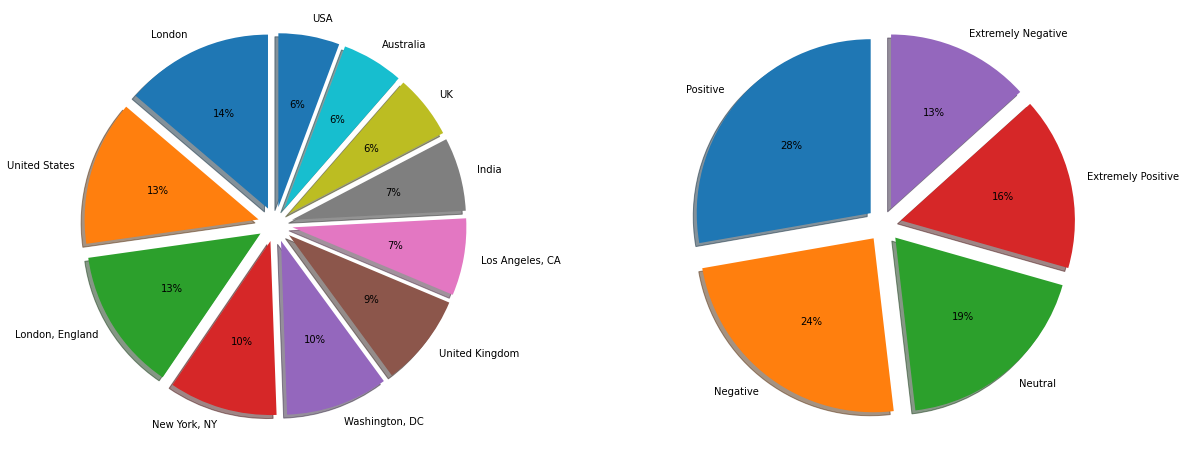

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

plot_pie(df_train, 'Location', axes[0], amount= 11)
plot_pie(df_train, 'Sentiment', axes[1])
plt.show()

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


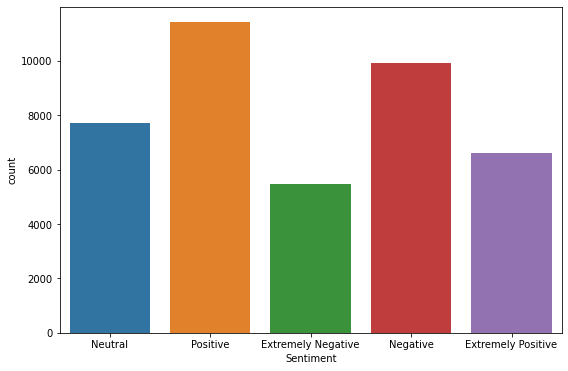

In [13]:
plt.figure(figsize= (9, 6))
sns.countplot(x = "Sentiment", data = df_train);

## Pre-Processing data


### Clean data 
1. ***Stop-Word Removal*** : In English words like a, an, the, as, in, on, etc. are considered as stop-words so according to our requirements we can remove them to reduce vocabulary size as these words don't have some specific meaning

2. ***Lower Casing*** : Convert all words into the lower case because the upper or lower case may not make a difference for the problem. And we are reducing vocabulary size by doing so.

3. ***Stemming*** : Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “walk” and “walking” are both reduced to “walk”).

4. ***Tokenization***: NLP software typically analyzes text by breaking it up into words (tokens) and sentences.


In [14]:
# Check NaN
df_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [15]:
df_test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [16]:
# check duplicated
df_train.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

In [17]:
# Remove NaN
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

In [18]:
# Drop columns which we don't require

waste_col = ['UserName', 'ScreenName', 'Location', 'TweetAt']

train_data = df_train.drop(waste_col, axis = 1)
test_data = df_test.drop(waste_col, axis = 1)

In [19]:
train_data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive


In [20]:
# Convert sentiment into number
def sentiment(x):
    '''
    Nummerical sentiment columns
    Extremely Positive: 1
    Positive: 1
    Neutral: 0
    Nagetive: -1
    Extremely Negative: -1
    '''

    if x == 'Extremely Positive' or x == 'Positive':
        return 1
    elif x == 'Neutral':
        return 0
    else:
        return -1

train_data['Sentiment'] = train_data['Sentiment'].map(sentiment)
test_data['Sentiment'] = test_data['Sentiment'].map(sentiment)

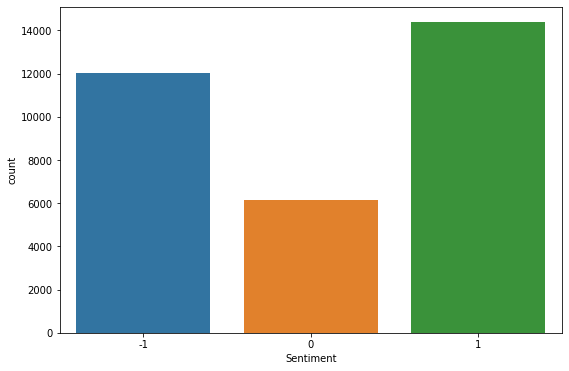

In [21]:
plt.figure(figsize = (9, 6))
sns.countplot(x = "Sentiment", data = train_data);

In [22]:
# Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')

    return url_remove.sub(r'', text)

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_urls)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_urls)

def remove_html(text):
    html = re.compile(r'<.?>')

    return html.sub(r'', text)

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_html)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_html)


In [23]:
# Lower casting
def lower(text):
    lower_text = text.lower()
    return lower_text

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(lower)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(lower)

# Number removal
def remove_num(text):
    remove = re.sub(r'\d+', ' ', text)
    return remove

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_num)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_num)


In [24]:
# Remove stopwords and Punctuations
nltk.download("stopwords")
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r'[^\w\s\d]','', text)
    return punct

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(punct_remove)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(punct_remove)

def remove_stopwords(text):
    ''' Custom function to remove the stopwords'''
    stopwords = ' '.join([word for word in str(text).split() if word not in STOPWORDS])
    return stopwords

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_stopwords)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Remove mentions and hashtag
def remove_mention(x):
    text = re.sub(r'@\w+','', x)
    return text

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_mention)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_mention)

def remove_hash(x):
    text = re.sub(r'#\w+', '', x)
    return text

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_hash)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_hash)

# Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r'\s+', ' ', text).strip()
    return space_remove

train_data['OriginalTweet'] = train_data['OriginalTweet'].map(remove_space)
test_data['OriginalTweet'] = test_data['OriginalTweet'].map(remove_space)

In [26]:
train_data

,OriginalTweet,Sentiment
0,menyrbie phil_gahan chrisitv,0
1,advice talk neighbours family exchange phone n...,1
2,coronavirus australia woolworths give elderly ...,1
5,news regionâs first confirmed covid case came ...,1
6,cashier grocery store sharing insights covid_ ...,1
...,...,...
41147,yâall really shitting much home covid coronavi...,-1
41149,still shocked number toronto supermarket emplo...,-1
41150,never weâd situation amp world going supermark...,1
41152,airline pilots offering stock supermarket shel...,0


### One-hot encoding


In [27]:
# Create data_vocal: vocabulary of words present in dataset
data_vocab = []

for text in train_data.OriginalTweet:
    for word in text:
        if word not in data_vocab:
            data_vocab.append(word)

In [28]:
#function to return one-hot representation of passed text
def get_onehot(text, vocab = data_vocab):

    onehot_encoded = []
    len_vocab = len(vocab)
    for word in text:
        temp = [0]*len_vocab
        temp[vocab.index(word) - 1] = 1
        onehot_encoded.append(temp)

    return onehot_encoded

In [29]:
# Test onehot encoded
sample_vocab = ['the', 'cat', 'sat', 'on', 'mat', 'dog', 'run', 'green', 'tree']

print("One Hot Representation for sentence \"the cat sat on the mat\" :")
get_onehot(['the', 'cat', 'sat', 'on', 'the', 'mat'], sample_vocab)

One Hot Representation for sentence "the cat sat on the mat" :


[[0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0, 0, 0]]

One-hot encoding is intuitive to understand and straightforward to implement. However, it has lots of disadvantages listed below

1. The size of a one-hot vector is directly proportional to the size of the vocabulary and if we consider a real-world vocabulary size it may be in millions so we can not represent a single word with a million-dimensional vector.

2. One-hot representation does not give a fixed-length representation for text, i.e., the sentence with 32 words in it and 40 words in it has variable length representation. But for most learning algorithms, we need the feature vectors to be of the same length.

3. One-Hot representation gives each word the same weight whether that word is important for the task or not.

4. One-Hot representation does not represent the meaning of the word in a proper numerical manner as embedding vectors do. Consider an example word read, reading should have similar real-valued vector representation but in this case, they have different representations.

5. Let say we train the model on some article and get the vocabulary of size 10000 but what if we use this vocabulary on that text which contains words that are not present in learned vocabulary. This is Known as Out Of Vocabulary (OOV) problem.

### Bag of words (BoW)
Bag of words (BoW) is a classical text representation technique that has been used commonly in NLP, especially in text classification problems. The key idea behind it is as follows: represent the text under consideration as a bag (collection) of words while ignoring the order and context.

Similar to one-hot encoding, BoW maps words to unique integer IDs between 1 and |V|. Each document in the corpus is then converted into a vector of |V| dimensions were in the ith component of the vector, i = wid, is simply the number of times the word w occurs in the document, i.e., we simply score each word in V by their occurrence count in the document.

In [30]:
# Test BoW
from sklearn.feature_extraction.text import CountVectorizer

sample_bow = CountVectorizer()

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_bow.fit(sample_corpus)

def get_bow_representation(text):
    return sample_bow.transform(text)

In [31]:
print(f"Vocabulary mapping for given sample corpus : \n {sample_bow.vocabulary_}")
print("\nBag of word Representation of sentence 'the cat cat sat in the hat'")
print(get_bow_representation(["the cat cat sat in the hat"]).toarray())

Vocabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of word Representation of sentence 'the cat cat sat in the hat'
[[2 1 1 1 2 0]]


**Advantages of this Bag of words(BoW) encoding :**

1. Like one-hot encoding, BoW is fairly simple to understand and implement.

2. With this representation, documents having the same words will have their vector representations closer to each other in Euclidean space as compared to documents with completely different words.

  Consider an example Where


    S1 = "cat on the mat" --> BoW Representation --> {0 1 1 0 1 0 1}
    S2 = "mat on the cat" --> BoW Representation --> {0 1 1 0 1 0 1}
    S3 = "dog in the mat" --> BoW Representation --> {0 1 0 1 1 1 0}

The distance between S1 and S2 is 0 as compared to the distance between S1 and S3, which is 2. Thus, the vector space resulting from the BoW scheme captures the semantic similarity of documents. So if two documents have a similar vocabulary, they’ll be closer to each other in the vector space and vice versa.

3. We have a fixed-length encoding for any sentence of arbitrary length.


**Disadvantages of this Bag of words(BoW) encoding :**

1. The size of the vector increases with the size of the vocabulary as in our case it is 14238 dimensional. Thus, sparsity continues to be a problem. One way to control it is by limiting the vocabulary to n number of the most frequent words.

2. It does not capture the similarity between different words that mean the same thing. Say we have three documents: “walk”, “walked”, and “walking”. BoW vectors of all three documents will be equally apart.

3. This representation does not have any way to handle out of vocabulary (OOV) words (i.e., new words that were not seen in the corpus that was used to build the vectorizer).

4. As the name indicates, it is a “bag” of words—word order information is lost in this representation. Both S1 and S2 will have the same representation in this scheme.

### TF-IDF
**Mathematically, this is captured using two quantities: TF and IDF. The two are then multiplied to arrive at the TF-IDF score.**

**TF (term frequency) measures how often a term or word occurs in a given document**

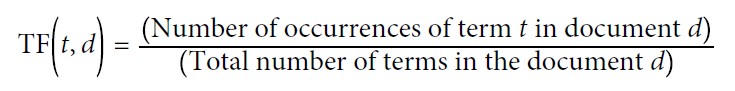
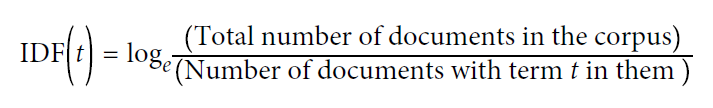



In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = train_data['OriginalTweet'].tolist()
y = train_data['Sentiment'].tolist()

X_train, y_train, X_val, y_val = train_test_split(X, y, 
                                                  test_size = 0.2,
                                                  random_state = 42)


tfidf = TfidfVectorizer(sublinear_tf= True, min_df = 5,
                      stop_words = 'english')

# Transform each text into a vector
features = tfidf.fit_transform(train_data.OriginalTweet).toarray()

labels = train_data.Sentiment
print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 32567 tweets is represented by 9249 features (TF-IDF score of unigrams and bigrams)


## Model

### Build A custom model in Sklearn  

In [33]:
from pandas.core.common import random_state
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators= 100, max_depth= 5, random_state = 42),
    LinearSVC(),
    MultinomialNB()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index = range(CV * len(models)))


entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies  = cross_val_score(model, 
                               features, labels, 
                               scoring = 'accuracy',
                               cv = CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries,
                     columns = ['model_name', 'fold_idx', 'accuracy'])


In [34]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis = 1, ignore_index = True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc


,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.770965,0.008418
MultinomialNB,0.651242,0.004626
RandomForestClassifier,0.472502,0.009597


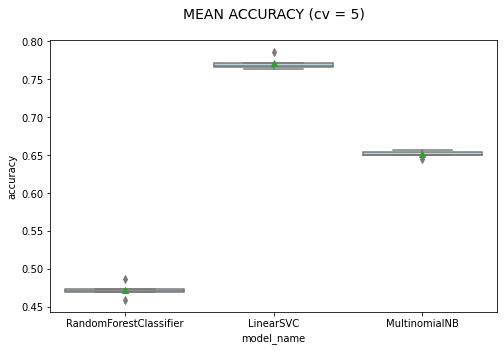

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [36]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train_data.index, test_size=0.2, 
                                                               random_state=42)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
# Classification report 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.79      0.78      0.78      2403
           0       0.68      0.64      0.66      1240
           1       0.81      0.84      0.83      2871

    accuracy                           0.78      6514
   macro avg       0.76      0.75      0.76      6514
weighted avg       0.78      0.78      0.78      6514



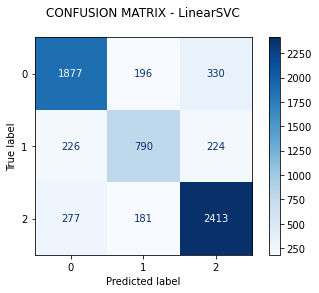

In [38]:
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels= None)
disp.plot(cmap ='Blues')
plt.title("CONFUSION MATRIX - LinearSVC\n");
plt.show();

### Build A custom model in TensorFlow  

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [40]:
X_train = train_data['OriginalTweet']
X_test = test_data['OriginalTweet']

y_train = train_data['Sentiment']
y_test = test_data['Sentiment']

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

In [42]:
# Maxiumn lenght of sequence 
max_len = np.max(X_train.apply(lambda x: len(x)))
max_len

266

In [43]:
# Tokenizer init
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [44]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [45]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 50577
Max sequence length: 266


In [46]:
embedding_dim = 16

In [47]:
X_train[4].shape

(266,)

In [61]:
# Create model using Functional API
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 266, 16)           809232    
                                                                 
 bidirectional_1 (Bidirectio  (None, 266, 512)         559104    
 nal)                                                            
                                                                 
 global_average_pooling1d_1   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                

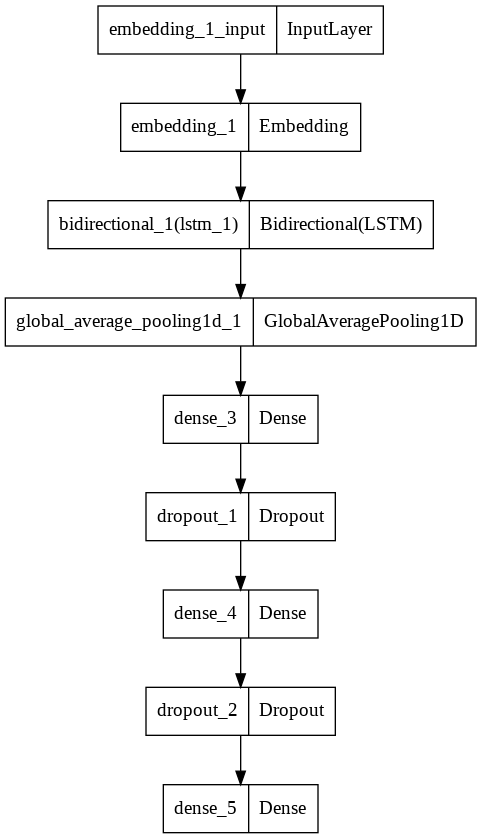

In [62]:
tf.keras.utils.plot_model(model)

In [64]:
# Fit model 
num_epochs = 20
history = model.fit(X_train, y_train, epochs=num_epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20
1018/1018 [==============================] - 35s 34ms/step - loss: 1.0442 - accuracy: 0.4416 - val_loss: 1.0350 - val_accuracy: 0.4072
Epoch 2/20
1018/1018 [==============================] - 32s 32ms/step - loss: 1.0441 - accuracy: 0.4416 - val_loss: 1.0346 - val_accuracy: 0.4072
Epoch 3/20
1018/1018 [==============================] - 33s 32ms/step - loss: 1.0441 - accuracy: 0.4416 - val_loss: 1.0351 - val_accuracy: 0.4072
Epoch 4/20
1018/1018 [==============================] - 33s 32ms/step - loss: 1.0441 - accuracy: 0.4416 - val_loss: 1.0367 - val_accuracy: 0.4072
Epoch 5/20
1018/1018 [==============================] - 32s 32ms/step - loss: 1.0441 - accuracy: 0.4416 - val_loss: 1.0353 - val_accuracy: 0.4072
Epoch 6/20
1018/1018 [==============================] - 33s 32ms/step - loss: 1.0441 - accuracy: 0.4416 - val_loss: 1.0356 - val_accuracy: 0.4072
Epoch 7/20
1018/1018 [==============================] - 33s 32ms/step - loss: 1.0441 - accuracy: 0.4416 - val_loss: 1.0347 -

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

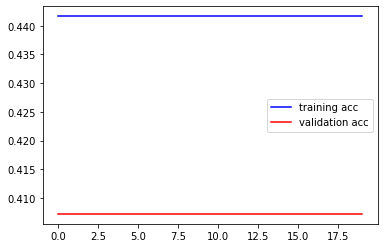

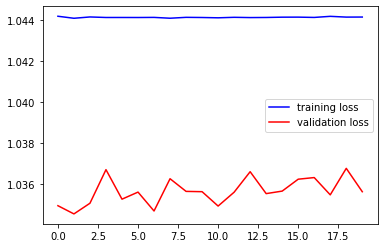

In [66]:
epochs = range(len(acc))

# Visualize Loss
plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()

# Visualize Accuracy
plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()